<a href="https://colab.research.google.com/github/joSanchez28/Machine-Learning-Projects/blob/master/FineTuning_BERT_on_Tweets.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install transformers

     |████████████████████████████████| 573kB 2.8MB/s 
     |████████████████████████████████| 1.0MB 38.8MB/s 
     |████████████████████████████████| 3.7MB 34.4MB/s 
     |████████████████████████████████| 890kB 34.8MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.41-cp36-none-any.whl size=893334 sha256=24ef95faa7b22b2d25d82dd8c46eff193f925055c3c0a96d0c2c39338a3f517f
  Stored in directory: /root/.cache/pip/wheels/22/5a/d4/b020a81249de7dc63758a34222feaa668dbe8ebfe9170cc9b1
Successfully built sacremoses


In [0]:
import os

import tensorflow as tf
import tensorflow_datasets

from transformers import (
    BertConfig,
    #BertForSequenceClassification,
    BertTokenizer,
    TFBertForSequenceClassification,
    glue_convert_examples_to_features,
    glue_processors,
)

In [3]:
# script parameters
BATCH_SIZE = 32
EVAL_BATCH_SIZE = BATCH_SIZE * 2
USE_XLA = False
USE_AMP = False
EPOCHS = 3

TASK = "sst-2"

if TASK == "sst-2":
    TFDS_TASK = "sst2"
elif TASK == "sts-b":
    TFDS_TASK = "stsb"
else:
    TFDS_TASK = TASK

num_labels = len(glue_processors[TASK]().get_labels())
print(num_labels)

tf.config.optimizer.set_jit(USE_XLA)
tf.config.optimizer.set_experimental_options({"auto_mixed_precision": USE_AMP})

2


In [4]:
# Load tokenizer and model from pretrained model/vocabulary. Specify the number of labels to classify (2+: classification, 1: regression)
config = BertConfig.from_pretrained("bert-base-cased", num_labels=num_labels)
tokenizer = BertTokenizer.from_pretrained("bert-base-cased")
model = TFBertForSequenceClassification.from_pretrained("bert-base-cased", config=config)

## NOS SALTAMOS ESTO PARA USAR NUESTROS DATOS:

In [0]:
# Load dataset via TensorFlow Datasets
#data, info = tensorflow_datasets.load(f"glue/{TFDS_TASK}", with_info=True)
#train_examples = info.splits["train"].num_examples

In [0]:
#type(data['test'])

In [0]:
#data

In [0]:
#data["train"]

In [0]:
#for idx, feat, targ in data["train"].take(5):
#  print ('Idx: {}, Features: {}, Target: {}'.format(idx, feat, targ))

In [0]:
#for dict_slice in data["train"].take(1):
#  print (dict_slice)

In [0]:
#info

In [0]:
# MNLI expects either validation_matched or validation_mismatched
#valid_examples = info.splits["validation"].num_examples

# Prepare dataset for GLUE as a tf.data.Dataset instance
#train_dataset = glue_convert_examples_to_features(data["train"], tokenizer, max_length=128, task=TASK)

In [0]:
#valid_examples

In [0]:
#type(train_dataset)

In [0]:
#train_dataset

In [0]:
# MNLI expects either validation_matched or validation_mismatched
#valid_dataset = glue_convert_examples_to_features(data["validation"], tokenizer, max_length=128, task=TASK)

## USAMOS NUESTROS DATOS

In [17]:
import pandas as pd
import re
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Load the dataset of tweets:

In [18]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [19]:
# DATASET
DATASET_COLUMNS = ["target", "ids", "date", "flag", "user", "text"]
DATASET_ENCODING = "ISO-8859-1"
TRAIN_SIZE = 0.8
# TEXT CLENAING
TEXT_CLEANING_RE = "@\S+|https?:\S+|http?:\S|[^A-Za-z0-9,;:.']+" #La última indica lo que dejamos; BERT sí trabaja con signos de puntuación.

dataset_filename = "training.1600000.processed.noemoticon.csv"
dataset_path = "/content/drive/My Drive/" + dataset_filename
print("Open file:", dataset_path)
df = pd.read_csv(dataset_path, encoding =DATASET_ENCODING , names=DATASET_COLUMNS)

Open file: /content/drive/My Drive/training.1600000.processed.noemoticon.csv


In [20]:
print(df["text"][0])

@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer.  You shoulda got David Carr of Third Day to do it. ;D


Remove links and users from the tweets:


In [0]:
def preprocess(text):
    # Remove link,user and special characters
    text = re.sub(TEXT_CLEANING_RE, ' ', text).strip()
    return text

In [0]:
df.text = df.text.apply(lambda x: preprocess(x))

In [23]:
print(df["text"][0])

Awww, that's a bummer. You shoulda got David Carr of Third Day to do it. ;D


Cambiamos las labels postivas de 4 a 1.

In [24]:
df.target.value_counts()

4    800000
0    800000
Name: target, dtype: int64

In [0]:
decode_map = {0: 0, 4: 1}
def decode_sentiment(label):
    return decode_map[int(label)]

df.target = df.target.apply(lambda x: decode_sentiment(x))

In [26]:
df.target.value_counts()

1    800000
0    800000
Name: target, dtype: int64

### Create the dataset

In [0]:
df_relevante = df[["target","text"]]

In [0]:
df_relevante.columns = ["label", "sentence"]
df_relevante.index.name = "idx"

In [0]:
df_relevante = df_relevante.reset_index()

In [30]:
df_relevante.head()

,idx,label,sentence
0,0,0,"Awww, that's a bummer. You shoulda got David C..."
1,1,0,is upset that he can't update his Facebook by ...
2,2,0,I dived many times for the ball. Managed to sa...
3,3,0,my whole body feels itchy and like its on fire
4,4,0,"no, it's not behaving at all. i'm mad. why am ..."


#### Split the dataset

In [0]:
df_train, df_test = train_test_split(df_relevante, test_size = 0.2, random_state = 0, stratify = df_relevante.label.values)
df_val, df_test = train_test_split(df_test, test_size = 0.5, random_state = 0, stratify = df_test.label.values)

In [32]:
df_train.shape

(1280000, 3)

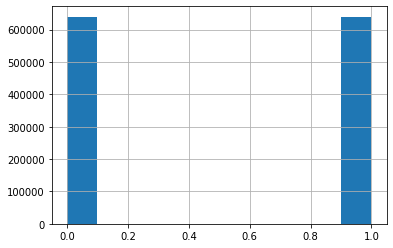

In [33]:
df_train.label.hist()

In [34]:
df_test.shape

(160000, 3)

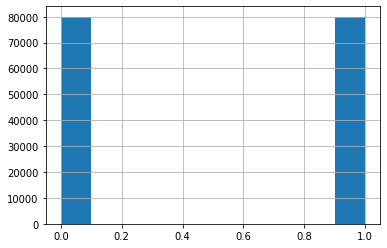

In [35]:
df_test.label.hist()

#### Dataset from pandas to Tensorflow

In [36]:
train_examples = df_train.shape[0]
valid_examples = df_val.shape[0]
print(train_examples)
print(valid_examples)

1280000
160000


In [0]:
data_train = tf.data.Dataset.from_tensor_slices(df_train.to_dict('list'))

In [0]:
data_val = tf.data.Dataset.from_tensor_slices(df_val.to_dict('list'))

In [0]:
# Prepare dataset for GLUE as a tf.data.Dataset instance
train_dataset = glue_convert_examples_to_features(data_train, tokenizer, max_length=128, task=TASK)

In [0]:
valid_dataset = glue_convert_examples_to_features(data_val, tokenizer, max_length=128, task=TASK)

## ENTRENAMOS EL MODELO


In [0]:
# MNLI expects either validation_matched or validation_mismatched
train_dataset = train_dataset.shuffle(128).batch(BATCH_SIZE).repeat(-1)
valid_dataset = valid_dataset.batch(EVAL_BATCH_SIZE)

In [42]:
# Prepare training: Compile tf.keras model with optimizer, loss and learning rate schedule
opt = tf.keras.optimizers.Adam(learning_rate=3e-5, epsilon=1e-08)
if USE_AMP:
    # loss scaling is currently required when using mixed precision
    opt = tf.keras.mixed_precision.experimental.LossScaleOptimizer(opt, "dynamic")


if num_labels == 1:
    loss = tf.keras.losses.MeanSquaredError()
else:
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

metric = tf.keras.metrics.SparseCategoricalAccuracy("accuracy")
model.compile(optimizer=opt, loss=loss, metrics=[metric])

# Train and evaluate using tf.keras.Model.fit()
train_steps = train_examples // BATCH_SIZE
valid_steps = valid_examples // EVAL_BATCH_SIZE

history = model.fit(
    train_dataset,
    epochs=EPOCHS,
    steps_per_epoch=train_steps,
    validation_data=valid_dataset,
    validation_steps=valid_steps,
)

# Save TF2 model
os.makedirs("./save/", exist_ok=True)
model.save_pretrained("./save/")

Epoch 1/3
26142/40000 [==================>...........] - ETA: 1:50:08 - loss: 0.3610 - accuracy: 0.8405

KeyboardInterrupt: ignored